<code>create_SIE_clim_benchmark.ipynb</code> creates the damped anomaly forecast that we use for our benchmark forecast.  

### Overview

The damped anomaly forecast is a statistical model of sea ice that uses persistence and climatology to make a prediction of sea ice. We follow the same procedure described in Wayand et al. (2019).  This script has three parts:
1. Load observations [our main data set uses NASA Bootstrap but we'll also check with NASA Team] 
2. Calculate the observed climatology and the anomalies from climatology every year
    1.  We'll create the climatology from a rolling 10 year mean.  So for each observed day of the year, we'll average the past 10 years' SIE on that day. 
    2.  The idea behind this is that it's hard to remove long-term trends from forecast models; however, long term trends are definitely present in sea ice.  While the existence of long-term trends in day-to-day variability in the Arctic is less of a concern than for seasonal forecasting, it's still an issue.  The 10-year rolling mean climatology helps with that by "moving the box" along.  
3. Make our damped anomaly forecast:
    1.  CC previously calculated the lag-1 (7 day) autocorrelation coefficients for NASA Bootstrap.  We'll use those because they were a pain to calculate.  Since she did this a year or two ago, we'll truncate our obs in 2018 to match hers. 
    2.  The lag-1 autocorrelation coefficients ($\alpha$) are a function of region and day of year.  So each region will have 365 of them. 
    3.  Our damped anomaly ($D$) is essentially: $ D[region,date] = SIE_{anom}[date]\cdot\alpha[doy] + SIE_{clim}[doy]$.  Since $date$ includes the day of year, we'll use that part of the full date to select $\alpha$ and $SIE_{clim}$.  

### Calculating the Damped Anomaly

Now, we'll calculate the damped anomaly.  The damped anomaly is defined using the climatological trend, calculated above, and then adding a damped anomaly. Following Wayand et al. (2019):

$$SIE_{damped}(doy_I,doy_V) = SIE_{clim}(doy_V) + D(doy_i,doy_v)$$ 

where $doy_I$ and $doy_V$ are the initial and valid days of the year, respectively.  $D$, the damped anomaly, is modeled baesd on a first-order autoregressive (AR-1) process:

$$D(doy_I,doy_V) = [SIE_{obs}(doy_I) - SIE_{clim}(doy_I)]\alpha (doy_I,doy_V)$$

$SIE_O$ is the most recent observation available on $doy_I$.  $\alpha$ is the correlation between SIE at each combination of $I$ and $V$ from our observations.  Calculating $\alpha$ for every combination is expensive, so we'll follow Wayand et al. (2019)'s Equation 3 and approximate $\alpha$ based on a one-week lagged autocorrelation: 

$$\alpha(doy_I,doy_V) \approx \left< SIE_{obs}(doy_I), SIE_{obs}(doy_I + 7) \right>^{n/7} $$

$n$ is the lead time in days

In [2]:
import xarray as xr
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.linear_model import LinearRegression 
from sklearn.model_selection import train_test_split, cross_val_score, LeaveOneOut  
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from S2S_sea_ice_preprocess import create_obs_climatology_ROLLING, create_obs_climatology

### Part 1. 
Load observations.  NSIDC_0079 is NASA Bootstrap, NSIDC_0051 is NASA team. Our main analysis is based on NASA bootstrap but we double-check with NASA team.

In [3]:
obs_name = 'NSIDC_0051'
print('selected observations: ',obs_name)
clim_type = 'ROLLING'

selected observations:  NSIDC_0051


In [4]:
obs_type = 'sipn_nc_yearly_agg'
filepath = '/home/disk/sipn/nicway/data/obs/{model_name}/{model_type}/'.format(model_name=obs_name,
                                                                              model_type=obs_type)
obs_filenames = xr.open_mfdataset(filepath+'/*.nc',combine='by_coords')
print('opening ',obs_filenames)
obs_SIE = obs_filenames.Extent
obs_regions = obs_filenames.nregions
obs_region_names = obs_filenames['region_names'].values
# Drop region names and re-add as a non-dask.array object.  This is stupid but oh well
obs_SIE = obs_SIE.drop('region_names')
obs_SIE["region_names"] = ("nregions",obs_region_names)
print('obs loaded')

opening  <xarray.Dataset>
Dimensions:       (nregions: 15, time: 11261)
Coordinates:
    region_names  (nregions) object dask.array<chunksize=(15,), meta=np.ndarray>
  * nregions      (nregions) int64 99 2 3 4 5 6 7 8 9 10 11 12 13 14 15
  * time          (time) datetime64[ns] 1989-01-01 1989-01-02 ... 2019-10-31
Data variables:
    Extent        (time, nregions) float64 dask.array<chunksize=(365, 15), meta=np.ndarray>
obs loaded


Convert to a Pandas dataframe (because I like Pandas), and rename a few columns for housekeeping

In [5]:
#obs_SIE = create_aggregate_regions(obs_SIE)
obs_SIE = obs_SIE.to_dataframe().reset_index()
obs_SIE = obs_SIE.rename(columns={'Extent':'SIE','region_names':'region','time':'valid date'})
obs_SIE

,valid date,nregions,region,SIE
0,1989-01-01,99,panArctic,14.132872
1,1989-01-01,2,Sea of Okhotsk,0.305643
2,1989-01-01,3,Bering,0.565830
3,1989-01-01,4,Hudson Bay,1.233464
4,1989-01-01,5,St John,0.105265
...,...,...,...,...
168910,2019-10-31,11,East Siberian Sea,1.108667
168911,2019-10-31,12,Chukchi Sea,0.078467
168912,2019-10-31,13,Beaufort Sea,0.622577
168913,2019-10-31,14,Canadian Islands,0.645554


For the damped anomaly, our estimates of autocorrelation are based on SIE obs from 1979-2018, so we'll drop the our 2019 obs of SIE from NASA Bootstrap

In [6]:
last_year = 2017 # Last year included in CC's calculations
obs_SIE = obs_SIE[obs_SIE['valid date'].dt.year.isin(np.arange(1979,last_year+1))]

### Part 2 
Calculate observed climatology from a 10-year rolling mean using <code>create_obs_climatology_ROLLING</code>

In [7]:
n_years = 10
if clim_type == 'ROLLING': 
    obs_SIE = create_obs_climatology_ROLLING(obs_SIE,n_years)
    print('observed climatology created: rolling mean')
elif clim_type == 'STATIC':
    obs_SIE = create_obs_climatology(obs_SIE)
    print('observed climatology created: static')

/home/disk/sipn/mcmcgraw/McGraw_etal_2020/code/make_it_nice/FINAL/CODE/S2S_sea_ice_preprocess.py:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SIE['valid day of year'] = pd.to_datetime(SIE['valid date']).dt.strftime('%m-%d')


observed climatology created: rolling mean


/home/disk/sipn/mcmcgraw/McGraw_etal_2020/code/make_it_nice/FINAL/CODE/S2S_sea_ice_preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SIE['SIE clim'] = SIE.groupby(['region','valid day of year'])['SIE'].transform(lambda x: x.rolling(n_years,min_periods=n_years).mean())
/home/disk/sipn/mcmcgraw/McGraw_etal_2020/code/make_it_nice/FINAL/CODE/S2S_sea_ice_preprocess.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SIE['SIE anom'] = SIE['SIE'] - SIE['SIE clim']


Quick plot just to make sure everything looks ok.  Things we are looking for:
   1. Because we did a 10-year rolling mean, the first 10 years of <code>SIE clim</code> should be NaN
   2. <code>SIE</code> and <code>SIE clim</code> should look pretty similar, with peaks/troughs in <code>SIE</code> generally being bigger
   3. <code>SIE anom</code> (<code>SIE - SIE clim</code>) should be centered around 0, should be much smaller than <code>SIE</code> and <code>SIE clim</code>, and its largest values should coincide with spots where <code>SIE</code> and <code>SIE clim</code> are most different

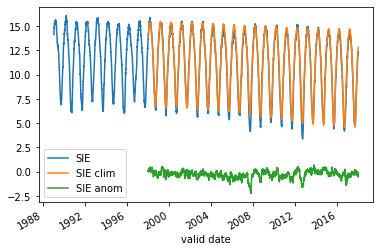

In [8]:
obs_SIE.where(obs_SIE['region']=='panArctic').plot(x='valid date',y=['SIE','SIE clim','SIE anom'])

Great! Now we just drop leap days because they are annoying. 

In [9]:
obs_SIE = obs_SIE.where(obs_SIE['valid day of year']!='02-29').dropna(how='all')

### Part 3
Load $\alpha$ coefficients from Nic/CC's earlier files.  We're going to adjust the coordinates a bit (we'll convert the DoY to date of year) to match our SIE data better. The $\alpha$ coefficients have dimensions of region, init time (day of year of the initial date) and fore time (number of days since forecast). Note that for <code>fore_time</code>, the numbers 1-365 do NOT refer to the day of year of the forecast date--they refer to the number of days since the forecast was made (e.g., a Timedelta).  This is probably obvious to most people but I misunderstood that the first time. 

In [10]:
alpha_filepath = '/home/disk/sipn/nicway/data/obs/NSIDC_0079/alpha_agg/1990_2017_Alpha.nc'
alphas = xr.open_dataset(alpha_filepath)
alphas

<xarray.Dataset>
Dimensions:       (fore_time: 365, init_time: 365, nregions: 15)
Coordinates:
  * nregions      (nregions) int64 99 2 3 4 5 6 7 8 9 10 11 12 13 14 15
    region_names  (nregions) object ...
  * fore_time     (fore_time) int64 1 2 3 4 5 6 7 ... 360 361 362 363 364 365
  * init_time     (init_time) int64 1 2 3 4 5 6 7 ... 360 361 362 363 364 365
Data variables:
    alpha         (init_time, fore_time, nregions) float64 ...

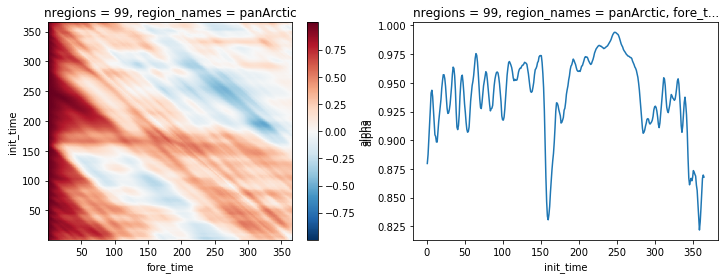

In [11]:
# Plot alpha, just for funsies.
fig1,(ax1a,ax1b) = plt.subplots(1,2,figsize=(12,4))
alphas.alpha.sel(nregions=99).plot(ax=ax1a)
#plt.axhline(y=244)
days_of_yr = pd.DataFrame(data={'valid day of year':pd.to_datetime(obs_SIE['valid date']).dt.strftime('%m-%d').unique()})
days_of_yr['doy'] = np.arange(1,366)
days_of_yr = days_of_yr.set_index('doy')
alphas.sel(fore_time=7,nregions=99).alpha.plot(ax=ax1b)

(left) $\alpha$ as a function of initialization day of year (y axis) and forecast time (x-axis, in Timdelta). The spring predictability barrier is very evident for the panArctic sea ice. (right) shows the value of $\alpha$ for each day of the year at a lead time of 7 days.

Get a list of the different region names and save them as a CSV so we have them easily accessible for later

In [12]:
regions_list = pd.DataFrame(columns=['nregions','region_names'])
regions_list['nregions'] = alphas.nregions
regions_list['region_names'] = alphas.region_names
regions_list.set_index('nregions')
save_regions = '/home/disk/sipn/mcmcgraw/McGraw_etal_2020/code/make_it_nice/data/REGIONS_LIST.csv'
regions_list.to_csv(save_regions)

### Part 4
Create the damped anomaly.  We use the $\alpha$ coefficients that CC made and we multiply the anomalous SIE by the alpha (damped anomaly), and add that back to the climatological SIE (see above for more discussion). 

We'll forecast for 7 days for this example so our code runs quickly, and we'll just pick one region at a time. 

In [14]:
max_fore = 7 #Maximum number of days we want to forecast for.
# Set up dataframe
SIE_forecast = pd.DataFrame(columns=['init date','valid date','lead time','SIE','SIE anom','SIE clim','region'])
# Select a region and get the name and nregion number
i_reg = 0
ireg_name = regions_list['region_names'].iloc[i_reg]
print('running ',ireg_name)
reg_num = regions_list['nregions'].iloc[i_reg]
obs_test = obs_SIE.where(obs_SIE['region']==ireg_name).dropna(how='all')
alpha_test = alphas.alpha.sel(nregions=reg_num)

running  panArctic


Now loop through each day of year and each forecast time and calculate the damped anomaly

<i>note to future self</i> this could be done with split-apply-combine

In [15]:
for i_doy in np.arange(1,366):

    for i_fore in np.arange(1,max_fore+1):
        #i_fore = 45
        if i_doy + i_fore > 365:
            f_doy = (i_doy + i_fore) - 365
        else:
            f_doy = i_doy + i_fore
        #
        # obs for the days we are forecasting
        obs_sel = obs_test.where(obs_test['valid day of year'].isin(days_of_yr.loc[i_doy].reset_index(drop=True).values)).dropna(how='all')
        # anom (SIE_actual - SIE_clim) * alpha(init,fore)
        d1 = obs_sel['SIE anom']*alpha_test.sel(init_time=i_doy,fore_time=i_fore).values
        obs_clim_sel = obs_test.where(obs_test['valid day of year'].isin(days_of_yr.loc[f_doy].reset_index(drop=True).values)).dropna(how='all')
        d2 = d1.values+obs_clim_sel['SIE clim'].values
        #obs_sel.plot(y=['SIE','SIE clim'])
        d3 = pd.DataFrame()
        d3['init date'] = obs_sel['valid date']
        d3['valid date'] = obs_sel['valid date'] + pd.Timedelta(i_fore,'D')
        d3['lead time'] = pd.Timedelta(i_fore,'D')
        d3['SIE'] = d2
        d3['SIE anom'] = d1.values
        d3['SIE clim'] = obs_sel['SIE clim']
        d3['region'] = obs_sel['region']
        SIE_forecast = SIE_forecast.append(d3)

Sanity check to make sure the damped anomaly and the obs are pretty close together

Text(0.5, 1.0, 'region: panArctic, includes lead times up to 7 days')

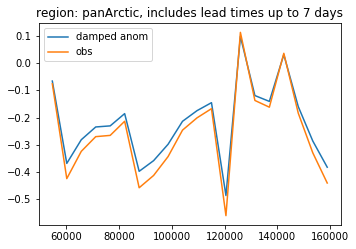

In [16]:
alpha_test.sel(init_time=i_doy,fore_time=f_doy).values
fig1 = plt.figure(1)
ax1 = fig1.add_axes([0,0,0.7,0.7])
d3['SIE anom'].plot(ax=ax1,label='damped anom')
obs_sel['SIE anom'].plot(ax=ax1,label='obs')
plt.legend()
plt.title('region: {reg}, includes lead times up to {nlead} days'.format(reg=ireg_name,
                                                                        nlead=max_fore)) 

Looks pretty good! Now, we're going to scale this and run it for all of our regions for a maximum of 60 forecast days. We'll save the damped anomaly forecast as a CSV file, and we'll calculate the RMSE in a separate script.

In [ ]:
#fpath_save = '/home/disk/sipn/mcmcgraw/McGraw_etal_2020/code/make_it_nice/data/'
#fname_save = fpath_save+'{obs_name}_DAMPED_ANOMALY_{clim_type}.csv'.format(obs_name=obs_name,clim_type=clim_type)
#SIE_forecast.to_csv(fname_save)